In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split

# Create learning dataset

In [63]:
dataset = pd.read_csv("../data/ready_to_use_datasets/lesfresnes.csv")

In [64]:
dataset["date"] = pd.to_datetime(dataset["date"])

In [65]:
X = dataset.drop(["reference_pm25", "microsensor_pm25", "date", "season"], axis=1)

In [66]:
X

,hourofday,monthofyear,temperature,humidity
0,0,1,13.21,99.9
1,0,1,13.21,99.9
2,0,1,12.92,99.9
3,0,1,12.92,99.9
4,0,1,13.21,99.9
...,...,...,...,...
753065,13,12,7.20,99.9
753066,13,12,7.20,99.9
753067,13,12,7.61,99.9
753068,13,12,7.61,99.9


## Scale data

In [67]:
scaler = MinMaxScaler()
X_cols = X.columns # Store column names
X = scaler.fit_transform(X)

## Construct labels

A microsensor measure is labeled wrong if the absolute difference with the reference station exceeds an arbitrarily chosen threshold.

In [68]:
# Construct labels
threshold = 3
y = abs(dataset["reference_pm25"] - dataset["microsensor_pm25"]) >= threshold

## Split training and testing sets

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

In [70]:
true_propor = sum(y_train) / len(y_train)
print(f"{round(true_propor * 100, 2)}% of the training measures are labeled as wrong.")

27.87% of the training measures are labeled as wrong.


In [71]:
balancer = SMOTE()
X_train, y_train = balancer.fit_resample(X_train, y_train)

In [72]:
true_propor = sum(y_train) / len(y_train)
print(
    f"{round(true_propor * 100, 2)}% of the training measures are labeled as wrong after the SMOTE resampling."
)

50.0% of the training measures are labeled as wrong after the SMOTE resampling.


# Logistic regression

## Train the model

In [73]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## Analyse model

### Metrics

In [74]:
y_pred = model.predict(X_test)

In [75]:
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

Precision: 0.3193809628036926
Accuracy: 0.5707820766141883
Recall: 0.47024700953536425


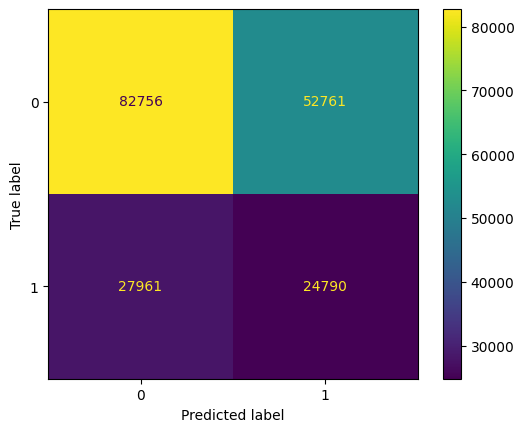

In [47]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [48]:
print(f"Proportion of predicted positive: {sum(y_pred) / len(y_pred)}")

Proportion of predicted positive: 0.4119181167272186


### Comparison with dummy classifier

In [49]:
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(X_test, y_test)
dummy_pred = dummy_model.predict(X_test)
print(f"Precision: {precision_score(y_test, dummy_pred)}")
print(f"Accuracy: {accuracy_score(y_test, dummy_pred)}")
print(f"Recall: {recall_score(y_test, dummy_pred)}")

Precision: 0.28053722602957715
Accuracy: 0.5000478041940213
Recall: 0.5012985535819227


### Feature importance

In [58]:
params = model.coef_.flatten()
print(params)

[-0.11651519 -0.36479441 -1.14274895 -0.65793192]


In [59]:
# Get absolute values as feature importance
params = abs(params)

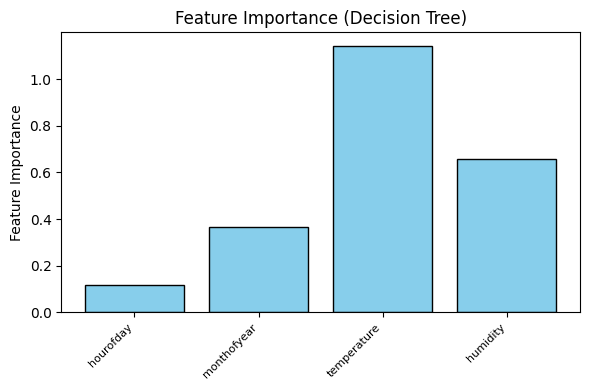

In [60]:
feature_names = X_cols

plt.figure(figsize=(6, 4))
plt.bar(
    range(len(params)),
    params,
    color="skyblue",
    edgecolor="black",
)
plt.xticks(
    range(len(feature_names)), feature_names, rotation=45, ha="right", fontsize=8
)
plt.ylabel("Feature Importance", fontsize=10)
plt.title("Feature Importance (Decision Tree)", fontsize=12)
plt.tight_layout()
plt.show()